# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

VGG网络是基于AlexNet的改进，主要思想是用多个小卷积核来代替一个大卷积核，使网络结构变得
复杂，学到更多信息的同时参数变得更少，网络变得更有效率。DenseNet主要是基于ResNet的改进，通过对特征图的重用，达到更浅的网络、更少的参数、更好的性能。DenseNet在设计网络的时候，也借鉴了VGG的结构，卷积层主要使用的是3×3的小卷积核。

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print(y_train[0])
# convert class vectors to binary class matrices.
#独热编码，将6转换成[0,0,0,0,0,0,1,0,0,0]
# y_train = to_categorical(y_train, num_classes)
# print('y_train shape:', y_train.shape)
# print(y_train[0])
from tensorflow.keras.datasets import cifar10from tensorflow.keras.datasets import cifar10# y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
[6]


In [3]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape((50000, 32, 32, 3)).astype('float32') / 255
x_test = x_test.reshape((10000, 32, 32, 3)).astype('float32') / 255


170500096/170498071 [==============================] - 4s 0us/step


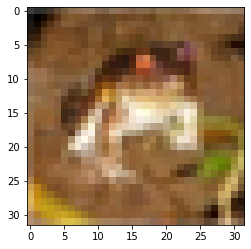

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-121 and DenseNet-169 as depicted in the original paper.

In [ ]:
# implement the code of your DenseNet-121 model here.
#https://keras.io/zh/layers/convolutional/
import tensorflow as tf
from tensorflow.keras import layers

#https://keras.io/zh/layers/writing-your-own-keras-layers/  Keras2.0needed
#2.2.4-tf Satisfied

# 瓶颈层，相当于每一个稠密块中若干个相同的H函数
class BottleNeck(layers.Layer):
    # growth_rate对应的是论文中的增长率k，指经过一个BottleNet输出的特征图的通道数；drop_rate指失活率。
    def __init__(self, growth_rate, drop_rate):
        super(BottleNeck, self).__init__()
        self.bn1 = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=4 * growth_rate,  # 使用1*1卷积核将通道数降维到4*k
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters=growth_rate,  # 使用3*3卷积核，使得输出维度（通道数）为k
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.dropout = layers.Dropout(rate=drop_rate)
        # 将网络层存入一个列表中
        self.listLayers = [self.bn1,
                           self.relu,
                           self.conv1,
                           self.bn2,
                           self.relu,
                           self.conv2,
                           self.dropout]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        # 每经过一个BottleNet，将输入和输出按通道连结。作用是：将前l层的输入连结起来，作为下一个BottleNet的输入。
        y = layers.concatenate([x, y], axis=-1)
        return y

# 稠密块，由若干个相同的瓶颈层构成
class DenseBlock(layers.Layer):
    # num_layers表示该稠密块存在BottleNet的个数，也就是一个稠密块的层数L
    def __init__(self, num_layers, growth_rate, drop_rate=0.5):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.drop_rate = drop_rate
        self.listLayers = []
        # 一个DenseBlock由多个相同的BottleNeck构成，我们将它们放入一个列表中。
        for _ in range(num_layers):
            self.listLayers.append(BottleNeck(growth_rate=self.growth_rate, drop_rate=self.drop_rate))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

# 过渡层
class TransitionLayer(layers.Layer):
    # out_channels代表输出通道数
    def __init__(self, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv = layers.Conv2D(filters=out_channels,
                                           kernel_size=(1, 1),
                                           strides=1,
                                           padding="same")
        self.pool = layers.MaxPool2D(pool_size=(2, 2),   # 2倍下采样
                                              strides=2,
                                              padding="same")

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

# DenseNet整体网络结构
class DenseNet(tf.keras.Model):
    # num_init_features:代表初始的通道数，即输入稠密块时的通道数
    # growth_rate:对应的是论文中的增长率k，指经过一个BottleNet输出的特征图的通道数
    # block_layers:每个稠密块中的BottleNet的个数
    # compression_rate:压缩因子，其值在(0,1]范围内
    # drop_rate：失活率
    def __init__(self, num_init_features, growth_rate, block_layers, compression_rate, drop_rate):
        super(DenseNet, self).__init__()
        # 第一层，7*7的卷积层，2倍下采样。
        self.conv = layers.Conv2D(filters=num_init_features,
                                           kernel_size=(7, 7),
                                           strides=2,
                                           padding="same")
        self.bn = layers.BatchNormalization()
        # 最大池化层，3*3卷积核，2倍下采样
        self.pool = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.relu = layers.ReLU()
        # 稠密块 Dense Block(1)
        self.num_channels = num_init_features
        self.dense_block_1 = DenseBlock(num_layers=block_layers[0], growth_rate=growth_rate, drop_rate=drop_rate)
        # 该稠密块总的输出的通道数
        self.num_channels += growth_rate * block_layers[0]
        # 对特征图的通道数进行压缩
        self.num_channels = compression_rate * self.num_channels
        # 过渡层1，过渡层进行下采样
        self.transition_1 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(2)
        self.dense_block_2 = DenseBlock(num_layers=block_layers[1], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[1]
        self.num_channels = compression_rate * self.num_channels
        # 过渡层2，2倍下采样，输出：14*14
        self.transition_2 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(3)
        self.dense_block_3 = DenseBlock(num_layers=block_layers[2], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[2]
        self.num_channels = compression_rate * self.num_channels
        # 过渡层3，2倍下采样
        self.transition_3 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(4)
        self.dense_block_4 = DenseBlock(num_layers=block_layers[3], growth_rate=growth_rate, drop_rate=drop_rate)

        # 全局平均池化，输出size：1*1
        self.avgpool = layers.GlobalAveragePooling2D()
        # 全连接层，进行10分类
        self.fc = layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.dense_block_1(x)
        x = self.transition_1(x)
        x = self.dense_block_2(x)
        x = self.transition_2(x)
        x = self.dense_block_3(x)
        x = self.transition_3(x,)
        x = self.dense_block_4(x)

        x = self.avgpool(x)
        x = self.fc(x)

        return x
    
def densenet_121():
    return DenseNet(num_init_features=64, growth_rate=32, block_layers=[6, 12, 24, 16], compression_rate=0.5, drop_rate=0.5)

densenet_121 = densenet_121()

densenet_121.build(input_shape=(50000, 32, 32, 3))

densenet_121.summary()


Model: "dense_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_408 (Conv2D)          multiple                  9472      
_________________________________________________________________
batch_normalization_408 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling multiple                  0         
_________________________________________________________________
re_lu_210 (ReLU)             multiple                  0         
_________________________________________________________________
dense_block_12 (DenseBlock)  multiple                  339264    
_________________________________________________________________
transition_layer_9 (Transiti multiple                  33920     
_________________________________________________________________
dense_block_13 (DenseBlock)  multiple                  

In [32]:
# implement the code of your DenseNet-169 model here.
def densenet_169():
    return DenseNet(num_init_features=64, growth_rate=32, block_layers=[6, 12, 32, 32], compression_rate=0.5, drop_rate=0.5)

densenet_169 = densenet_169()

densenet_169.build(input_shape=(50000, 32, 32, 3))

densenet_169.summary()


Model: "dense_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_528 (Conv2D)          multiple                  9472      
_________________________________________________________________
batch_normalization_528 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling multiple                  0         
_________________________________________________________________
re_lu_272 (ReLU)             multiple                  0         
_________________________________________________________________
dense_block_16 (DenseBlock)  multiple                  339264    
_________________________________________________________________
transition_layer_12 (Transit multiple                  33920     
_________________________________________________________________
dense_block_17 (DenseBlock)  multiple                  

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

Epoch 1/30
704/704 - 29s - loss: 1.4656 - accuracy: 0.4719 - val_loss: 3.2847 - val_accuracy: 0.2366
Epoch 2/30
704/704 - 26s - loss: 1.2969 - accuracy: 0.5346 - val_loss: 1.8024 - val_accuracy: 0.3746
Epoch 3/30
704/704 - 27s - loss: 1.1703 - accuracy: 0.5835 - val_loss: 1.7608 - val_accuracy: 0.3746
Epoch 4/30
704/704 - 26s - loss: 1.0680 - accuracy: 0.6188 - val_loss: 1.7015 - val_accuracy: 0.3848
Epoch 5/30
704/704 - 26s - loss: 0.9847 - accuracy: 0.6522 - val_loss: 2.3902 - val_accuracy: 0.2970
Epoch 6/30
704/704 - 26s - loss: 0.9177 - accuracy: 0.6768 - val_loss: 1.6909 - val_accuracy: 0.4736
Epoch 7/30
704/704 - 26s - loss: 0.8564 - accuracy: 0.6986 - val_loss: 2.1093 - val_accuracy: 0.4742
Epoch 8/30
704/704 - 26s - loss: 0.8007 - accuracy: 0.7200 - val_loss: 1.9798 - val_accuracy: 0.4348
Epoch 9/30
704/704 - 26s - loss: 0.7508 - accuracy: 0.7371 - val_loss: 0.8776 - val_accuracy: 0.7036
Epoch 10/30
704/704 - 26s - loss: 0.7062 - accuracy: 0.7536 - val_loss: 1.0302 - val_accura

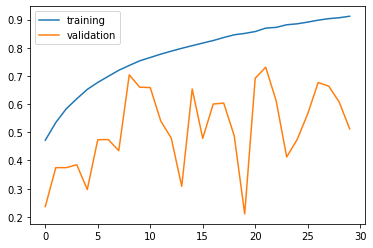

In [25]:
# implement your code here.
#Train densenet_121

densenet_121.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = densenet_121.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,verbose=2,
                    validation_split=0.1)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [28]:
#训练30个epoch后，得到的测试集准确率不够，再接着训练10个epoch
densenet_121.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = densenet_121.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,verbose=2,
                    validation_split=0.1)

Epoch 1/10
704/704 - 30s - loss: 0.2300 - accuracy: 0.9176 - val_loss: 1.0783 - val_accuracy: 0.7728
Epoch 2/10
704/704 - 28s - loss: 0.2116 - accuracy: 0.9248 - val_loss: 3.5938 - val_accuracy: 0.5590
Epoch 3/10
704/704 - 27s - loss: 0.2073 - accuracy: 0.9252 - val_loss: 5.2963 - val_accuracy: 0.3328
Epoch 4/10
704/704 - 28s - loss: 0.1996 - accuracy: 0.9284 - val_loss: 1.4474 - val_accuracy: 0.7344
Epoch 5/10
704/704 - 28s - loss: 0.1788 - accuracy: 0.9352 - val_loss: 1.4329 - val_accuracy: 0.7484
Epoch 6/10
704/704 - 28s - loss: 0.1788 - accuracy: 0.9353 - val_loss: 1.4609 - val_accuracy: 0.7376
Epoch 7/10
704/704 - 28s - loss: 0.1672 - accuracy: 0.9400 - val_loss: 2.8642 - val_accuracy: 0.5902
Epoch 8/10
704/704 - 28s - loss: 0.1681 - accuracy: 0.9405 - val_loss: 3.1536 - val_accuracy: 0.5922
Epoch 9/10
704/704 - 28s - loss: 0.1587 - accuracy: 0.9436 - val_loss: 1.4210 - val_accuracy: 0.7360
Epoch 10/10
704/704 - 28s - loss: 0.1477 - accuracy: 0.9483 - val_loss: 1.5392 - val_accura

In [29]:
#训练30个epoch后，得到的测试集准确率不够，再接着训练10个epoch
densenet_121.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = densenet_121.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,verbose=2,
                    validation_split=0.1)

Epoch 1/10
704/704 - 32s - loss: 0.1378 - accuracy: 0.9505 - val_loss: 3.4830 - val_accuracy: 0.5870
Epoch 2/10
704/704 - 29s - loss: 0.1303 - accuracy: 0.9546 - val_loss: 4.1981 - val_accuracy: 0.5680
Epoch 3/10
704/704 - 29s - loss: 0.1296 - accuracy: 0.9541 - val_loss: 1.8012 - val_accuracy: 0.7274
Epoch 4/10
704/704 - 28s - loss: 0.1259 - accuracy: 0.9550 - val_loss: 2.0835 - val_accuracy: 0.6856
Epoch 5/10
704/704 - 27s - loss: 0.1230 - accuracy: 0.9566 - val_loss: 1.3603 - val_accuracy: 0.7734
Epoch 6/10
704/704 - 27s - loss: 0.1037 - accuracy: 0.9621 - val_loss: 3.7385 - val_accuracy: 0.5968
Epoch 7/10
704/704 - 29s - loss: 0.1100 - accuracy: 0.9614 - val_loss: 6.5603 - val_accuracy: 0.4558
Epoch 8/10
704/704 - 29s - loss: 0.1174 - accuracy: 0.9586 - val_loss: 5.5320 - val_accuracy: 0.4396
Epoch 9/10
704/704 - 29s - loss: 0.1258 - accuracy: 0.9563 - val_loss: 15.2172 - val_accuracy: 0.1682
Epoch 10/10
704/704 - 29s - loss: 0.1299 - accuracy: 0.9567 - val_loss: 1.9671 - val_accur

In [33]:
#Train densenet_169
densenet_169.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = densenet_169.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,verbose=2,
                    validation_split=0.1)


Epoch 1/50
704/704 - 41s - loss: 2.1158 - accuracy: 0.2932 - val_loss: 2.2229 - val_accuracy: 0.2460
Epoch 2/50
704/704 - 38s - loss: 1.7120 - accuracy: 0.3963 - val_loss: 2.4802 - val_accuracy: 0.3126
Epoch 3/50
704/704 - 37s - loss: 1.5405 - accuracy: 0.4566 - val_loss: 2.5067 - val_accuracy: 0.3146
Epoch 4/50
704/704 - 37s - loss: 1.3970 - accuracy: 0.5132 - val_loss: 2.5383 - val_accuracy: 0.3010
Epoch 5/50
704/704 - 37s - loss: 1.2897 - accuracy: 0.5491 - val_loss: 2.2835 - val_accuracy: 0.3202
Epoch 6/50
704/704 - 38s - loss: 1.1866 - accuracy: 0.5836 - val_loss: 1.8165 - val_accuracy: 0.4212
Epoch 7/50
704/704 - 38s - loss: 1.1066 - accuracy: 0.6158 - val_loss: 2.2554 - val_accuracy: 0.4296
Epoch 8/50
704/704 - 39s - loss: 1.0242 - accuracy: 0.6403 - val_loss: 2.8961 - val_accuracy: 0.2856
Epoch 9/50
704/704 - 38s - loss: 0.9581 - accuracy: 0.6674 - val_loss: 6.3813 - val_accuracy: 0.1528
Epoch 10/50
704/704 - 38s - loss: 0.9012 - accuracy: 0.6880 - val_loss: 2.7654 - val_accura

### 4.2 Test your models. (5 marks)

In [30]:
# implement your code here.
#test densenet_121 
loss,accuracy = densenet_121.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

313/313 - 3s - loss: 1.9614 - accuracy: 0.7277
test loss 1.9614012241363525
test accuracy 0.7276999950408936


In [34]:
#test densenet_169 
loss,accuracy = densenet_169.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

313/313 - 5s - loss: 1.7371 - accuracy: 0.7418
test loss 1.737108826637268
test accuracy 0.7418000102043152


---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

In [6]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


base_model = DenseNet121(include_top=False,weights='imagenet',input_shape=(32,32,3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
predictions = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(x)
dense121_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

dense121_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

history = dense121_model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.1)
# implement your code here.

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/30
704/704 [==============================] - 27s 39ms/step - loss: 1.0143 - accuracy: 0.6541 - val_loss: 0.8309 - val_accuracy: 0.7164
Epoch 2/30
704/704 [==============================] - 25s 36ms/step - loss: 0.5686 - accuracy: 0.8021 - val_loss: 0.8126 - val_accuracy: 0.7214
Epoch 3/30
704/704 [==============================] - 25s 36ms/step - loss: 0.4091 - accuracy: 0.8576 - val_loss: 0.6574 - val_accuracy: 0.7922
Epoch 4/30
704/704 [==============================] - 25s 36ms/step - loss: 0.3020 - accuracy: 0.8958 - val_loss: 1.0350 - val_accuracy: 0.6888
Epoch 5/30
704/704 [==============================] - 25s 35ms/step - loss: 0.2313 - accuracy: 0.9189 - val_loss: 0.6851 - val_accuracy: 0.7888
Epoch 6/30
704/704 [==============================] - 25s 35ms/step - loss: 0.1778 - accuracy: 0.9392 - val_loss: 0.7114 - val_accuracy: 0.7974
Epoch 7/30
704/704 [==============================] - 25s 35ms/step - l

In [4]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


base_model = DenseNet121(include_top=False,weights=None,input_shape=(32,32,3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
predictions = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(x)
dense121_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

dense121_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

history = dense121_model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.1)

Epoch 1/30
704/704 [==============================] - 28s 40ms/step - loss: 1.7320 - accuracy: 0.3690 - val_loss: 2.2091 - val_accuracy: 0.2916
Epoch 2/30
704/704 [==============================] - 26s 36ms/step - loss: 1.4156 - accuracy: 0.4848 - val_loss: 4.0346 - val_accuracy: 0.1794
Epoch 3/30
704/704 [==============================] - 25s 36ms/step - loss: 1.2589 - accuracy: 0.5443 - val_loss: 1.6501 - val_accuracy: 0.4158
Epoch 4/30
704/704 [==============================] - 25s 36ms/step - loss: 1.1331 - accuracy: 0.5937 - val_loss: 1.6426 - val_accuracy: 0.4726
Epoch 5/30
704/704 [==============================] - 26s 36ms/step - loss: 1.0317 - accuracy: 0.6291 - val_loss: 2.8876 - val_accuracy: 0.3180
Epoch 6/30
704/704 [==============================] - 25s 36ms/step - loss: 0.9458 - accuracy: 0.6647 - val_loss: 3.6982 - val_accuracy: 0.2486
Epoch 7/30
704/704 [==============================] - 25s 35ms/step - loss: 0.8516 - accuracy: 0.6974 - val_loss: 1.9375 - val_accuracy:

In [5]:
#不使用imagenet预训练权重模型的结果
loss,accuracy = dense121_model.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

313/313 - 3s - loss: 3.2058 - accuracy: 0.4898
test loss 3.2058067321777344
test accuracy 0.48980000615119934


In [10]:
#使用imagenet预训练模型权重
loss,accuracy = dense121_model.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

313/313 - 3s - loss: 0.7618 - accuracy: 0.8437
test loss 0.7617789506912231
test accuracy 0.8436999917030334


In [9]:
base_model = DenseNet169(include_top=False,weights='imagenet',input_shape=(32,32,3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
predictions = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(x)
dense169_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

dense169_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

history = dense169_model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.1)

loss,accuracy = dense169_model.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)


Epoch 1/30
704/704 [==============================] - 37s 53ms/step - loss: 0.9751 - accuracy: 0.6636 - val_loss: 1.1039 - val_accuracy: 0.6404
Epoch 2/30
704/704 [==============================] - 34s 49ms/step - loss: 0.5332 - accuracy: 0.8148 - val_loss: 0.9029 - val_accuracy: 0.7014
Epoch 3/30
704/704 [==============================] - 34s 48ms/step - loss: 0.3646 - accuracy: 0.8741 - val_loss: 0.6474 - val_accuracy: 0.7946
Epoch 4/30
704/704 [==============================] - 33s 48ms/step - loss: 0.2473 - accuracy: 0.9150 - val_loss: 0.6929 - val_accuracy: 0.7882
Epoch 5/30
704/704 [==============================] - 34s 48ms/step - loss: 0.1763 - accuracy: 0.9402 - val_loss: 1.3457 - val_accuracy: 0.7020
Epoch 6/30
704/704 [==============================] - 33s 47ms/step - loss: 0.1322 - accuracy: 0.9550 - val_loss: 0.9970 - val_accuracy: 0.7228
Epoch 7/30
704/704 [==============================] - 33s 47ms/step - loss: 0.0925 - accuracy: 0.9689 - val_loss: 0.7198 - val_accuracy:

---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-169 better than DenseNet-121? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer: DenseNet-169模型表现的更好。在学习率等超参保持一致的情况下，两个模型训练50个epoch后，DenseNet-169在测试集上的准确率为74.2%,DenseNet-121的准确率为72.8%。测试集的准确率提高了。

2. Compare the results of your implementation with the pre-trained models from Keras. (10 marks)

Answer: 预训练模型网络训练的更快，在训练完第一个epoch后loss为0.98，准确率为66%。因为预训练模型中参数使用的是在imagenet中训练好的参数，而我们自定义模型中参数是随机初始化的。最后在训练完30个epoch后也表现的最好，测试集准确率为84%。

